In [2]:
import numpy as np
import math
import nest
import nest.raster_plot
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib import rcParams 
import os.path
import scipy as scp


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.3
 Built: May  5 2022 07:35:57

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [3]:
n_folder = 8

save = 0 

# 0: off, 1: save in folder n_folder

In [4]:
#MSO
C_mso = 1
delays_mso = [1,1.3,1,0.45,0.44] #ms

SBCs2MSO_weight = 1
SBCs2MSO_inh_weight = [0,-30]
MNTBCs2MSO_weights = [0,-30]

n_battery = len(MNTBCs2MSO_weights)

taus = np.zeros(4)
taus[:] = [0.2, 0.1, 0.5, 0.1]

In [10]:
# Variables
tones = [100] #[100,20,50,250,500,1000,2500,5000,10000,20000]
angles = [-45]
time_sim = 100 #us

#Considering ILD
mean_rate = 125
noise_rate = 0

ANFs2SBCs_weight = 2.0
ANFs2GBCs_weight = 1.0
GBCs2MNTBCs_weight = 16.0

SBCs2LSO_weight = 16.0
MNTBCs2LSO_weight = -2.0

V_m = -70 #mV
V_reset = -70 #mV

/home/ubuntu/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning:Covariance of the parameters could not be estimated


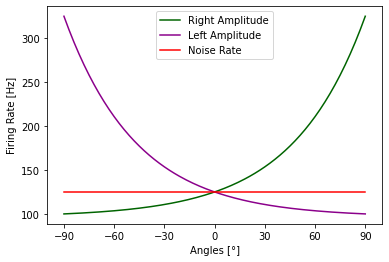

In [11]:
#ILD: computed considering the input sound at -80 dB and max_ILD = |20 dB|
max_amp = 325 #Hz
min_amp = 100

def expfunc(x, a, b, c):
    return a + (b * np.exp(c * x))

p_opt_r, p_cov = scp.optimize.curve_fit(expfunc, [-90,0,90], [min_amp,mean_rate,max_amp], bounds = ([-np.inf, 0, 0], [np.inf, np.inf, np.inf]))
p_opt_l, p_cov = scp.optimize.curve_fit(expfunc, [-90,0,90], [max_amp,mean_rate,min_amp], bounds = ([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf]))

fig, ax = plt.subplots(1)
ax.set_xlim(-100,100)
ax.set_xlabel("Angles [°]")
ax.set_ylabel("Firing Rate [Hz]")
ax.set_xticks(np.linspace(-90,90,7))
x = np.linspace(-90,90,181)
ax.plot(x, expfunc(x, *p_opt_r),  color = 'darkgreen', label = "Right Amplitude")
ax.plot(x,expfunc(x, *p_opt_l), color = 'darkmagenta', label = "Left Amplitude")
ax.axhline(y = mean_rate, xmin = 0.05, xmax = 0.95, color = 'r', label = "Noise Rate")
ax.legend()

(0.0, 400.0)

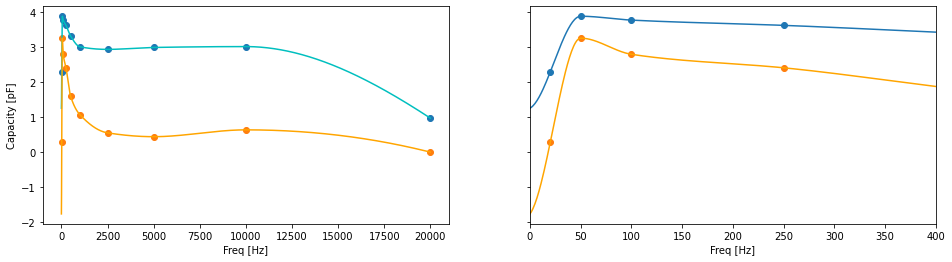

In [12]:
# New Capacities
cap_nuclei = 1 #pF
caps_sbc = np.loadtxt('/home/ubuntu/cosyne-tutorial-2022/results_caps/caps_sbc')
caps_gbc = np.loadtxt('/home/ubuntu/cosyne-tutorial-2022/results_caps/caps_gbc')
freqs = [20,50,100,250,500,1000,2500,5000,10000,20000]
eq_cap_sbc = scp.interpolate.PchipInterpolator(freqs, caps_sbc)
eq_cap_gbc = scp.interpolate.PchipInterpolator(freqs, caps_gbc)
#freq = np.round(np.logspace(np.log(20),np.log(20000), num = 3500, base = np.exp(1)),2)
#plt.plot(freq, pi(freq))
fig, ax = plt.subplots(1,2, figsize = (16,4), sharey = True)
ax[0].scatter(freqs,caps_sbc)
ax[0].plot(np.arange(20000), eq_cap_sbc(np.arange(20000)), 'c')
ax[0].scatter(freqs,caps_gbc)
ax[0].plot(np.arange(20000), eq_cap_gbc(np.arange(20000)), 'orange')
ax[0].set_xlabel("Freq [Hz]")
ax[0].set_ylabel("Capacity [pF]")
ax[1].scatter(freqs,caps_sbc)
ax[1].scatter(freqs,caps_gbc)
ax[1].plot(np.arange(20000), eq_cap_sbc(np.arange(20000)))
ax[1].plot(np.arange(20000), eq_cap_gbc(np.arange(20000)), 'orange')
ax[1].set_xlabel("Freq [Hz]")
ax[1].set_xlim([0,400])

In [13]:
# Fixed
w_head = 22 #cm
v_sound = 33000 #cm/s

n_ANFs = 35000
ANFs2SBCs = 4
ANFs2GBCs = 20
SBCs2MSOs = int(ANFs2GBCs/ANFs2SBCs)
SBCs2LSOs = int(ANFs2GBCs/ANFs2SBCs)
n_SBCs = int(n_ANFs/ANFs2SBCs)
n_GBCs = int(n_ANFs/ANFs2GBCs)
n_MSOs = n_GBCs*n_battery

In [14]:
#for C_m_bushy in caps:
    
    #rates = np.zeros((4,len(tones)))
    #nacs = np.zeros((4,len(tones)))
    
for tone in tones:
    
    C_m_scb = eq_cap_sbc(tone)
    C_m_gcb = eq_cap_gbc(tone)
    
    results_r_MSO = np.zeros((n_battery, len(angles)))
    results_l_MSO = np.zeros((n_battery, len(angles)))

    results_r_LSO = np.zeros(len(angles))
    results_l_LSO = np.zeros(len(angles))

    results_r_SBC = np.zeros(len(angles))
    results_l_SBC = np.zeros(len(angles))

    results_r_GBC = np.zeros(len(angles))
    results_l_GBC = np.zeros(len(angles))
    
    for angle in angles:

        nest.ResetKernel()
        nest.local_num_threads = 16
        nest.resolution = 0.01 # 10 us = minimum audible angle (MAA) increment of 1.25°

        freq = np.round(np.logspace(np.log(20),np.log(20000), num = 3500, base = np.exp(1)),2)
        channel_x = np.where(freq>=tone)[0][0]
        spectro = np.zeros((3500,time_sim))
        amplitudes = np.round(stats.norm.pdf(np.linspace(-1, 1, 21) , 0, 1.0/(math.sqrt(2*math.pi)*1)),2)

        if(channel_x<10):
            #spectro[channel_x, :] = np.ones(time_sim)
            spectro[channel_x:channel_x+10+1,:] = amplitudes[10:].reshape(11,1)*np.ones((11, time_sim))
            spectro[0:channel_x+1, :] = amplitudes[10-channel_x:11].reshape(channel_x+1,1)*np.ones((channel_x+1, time_sim))
        else:
            if(channel_x>3489):
                spectro[channel_x-10:channel_x+1] = amplitudes[:11].reshape(11,1)*np.ones((11, time_sim))
                spectro[channel_x:] = amplitudes[10:10+3500-channel_x].reshape(3500-channel_x,1)*np.ones((3500-channel_x, time_sim))
            else:
                #spectro[channel_x, :] = np.ones(time_sim)
                spectro[channel_x - 10 : channel_x + 10 + 1, :] = amplitudes.reshape(21,1)*np.ones((21, time_sim))

        delta_x = (w_head*np.sin(np.deg2rad(angle)))
        itd = 1000*delta_x/v_sound #ms
        ipds = 2*np.pi*itd*freq/1000

        # Populations

        r_ANFs_amp = nest.Create('sinusoidal_poisson_generator',n_ANFs,
                params={'frequency': np.repeat(freq, 10),
                            'phase': np.repeat(np.rad2deg(ipds),10)}) #ITDs

        l_ANFs_amp = nest.Create('sinusoidal_poisson_generator',n_ANFs,
                params={'frequency': np.repeat(freq, 10),
                            'phase': 0})


        r_ANFs = nest.Create('parrot_neuron', n_ANFs)

        l_ANFs = nest.Create('parrot_neuron',n_ANFs)

        r_SBCs = nest.Create('iaf_cond_alpha', n_SBCs, 
                         params = {'C_m': C_m_scb, 'V_reset': V_reset})

        l_SBCs = nest.Create('iaf_cond_alpha', n_SBCs, 
                         params = {'C_m': C_m_scb, 'V_reset': V_reset})

        r_GBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                         params = {'C_m': C_m_gcb, 'V_reset': V_reset})

        l_GBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                         params = {'C_m': C_m_gcb, 'V_reset': V_reset})


        r_MNTBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                         params = {'C_m': C_m_gcb, 'V_reset': V_reset})

        l_MNTBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                         params = {'C_m': C_m_gcb, 'V_reset': V_reset})

        r_MSO = nest.Create('iaf_cond_alpha', n_MSOs, 
                         params = {'C_m': cap_nuclei, 'V_reset': V_reset})

        l_MSO = nest.Create('iaf_cond_alpha', n_MSOs, 
                         params = {'C_m': cap_nuclei, 'V_reset': V_reset})

        r_LSO = nest.Create('iaf_cond_alpha', n_GBCs, 
                         params = {'C_m': cap_nuclei, 'V_reset': V_reset})

        l_LSO = nest.Create('iaf_cond_alpha', n_GBCs, 
                         params = {'C_m': cap_nuclei, 'V_m': V_m, 'V_reset': V_reset})

        ANFs_noise = nest.Create('poisson_generator',1,
                         params = {'rate':noise_rate})

        s_rec_r = nest.Create('spike_recorder')
        s_rec_l = nest.Create('spike_recorder')

        # Connections
        
        #Devices
        nest.Connect(r_ANFs, s_rec_r, 'all_to_all')
        nest.Connect(l_ANFs, s_rec_l, 'all_to_all')

        nest.Connect(r_SBCs, s_rec_r, 'all_to_all')
        nest.Connect(l_SBCs, s_rec_l, 'all_to_all')

        nest.Connect(r_GBCs, s_rec_r, 'all_to_all')
        nest.Connect(l_GBCs, s_rec_l, 'all_to_all')

        nest.Connect(r_MNTBCs, s_rec_r, 'all_to_all')
        nest.Connect(l_MNTBCs, s_rec_l, 'all_to_all')

        nest.Connect(r_MSO, s_rec_r, 'all_to_all')
        nest.Connect(l_MSO, s_rec_l, 'all_to_all')

        nest.Connect(r_LSO, s_rec_r, 'all_to_all')
        nest.Connect(l_LSO, s_rec_l, 'all_to_all')

        #ANFs
        
        nest.Connect(r_ANFs_amp, r_ANFs, 'one_to_one') 
        nest.Connect(l_ANFs_amp, l_ANFs, 'one_to_one')
        
        #ANF_noise to parrots
        for i in range(len(spectro)-1):
            if(np.any(spectro[i][:] > 0)):
                nest.Connect(ANFs_noise, r_ANFs[10*i:10*(i+1)], 'all_to_all')
                nest.Connect(ANFs_noise, l_ANFs[10*i:10*(i+1)], 'all_to_all')
        #ANF_parrots to SBCs
        for i in range(n_SBCs):
            nest.Connect(r_ANFs[ANFs2SBCs*i:ANFs2SBCs*(i+1)], r_SBCs[i], 'all_to_all', syn_spec = {"weight":ANFs2SBCs_weight})
            nest.Connect(l_ANFs[ANFs2SBCs*i:ANFs2SBCs*(i+1)], l_SBCs[i], 'all_to_all', syn_spec = {"weight":ANFs2SBCs_weight})
        #ANF_parrots to GBCs
        for i in range(n_GBCs):
            nest.Connect(r_ANFs[ANFs2GBCs*i:ANFs2GBCs*(i+1)], r_GBCs[i], 'all_to_all', syn_spec = {"weight":ANFs2GBCs_weight})
            nest.Connect(l_ANFs[ANFs2GBCs*i:ANFs2GBCs*(i+1)], l_GBCs[i], 'all_to_all', syn_spec = {"weight":ANFs2GBCs_weight})
        
        #GBCs to MNTBCs
        nest.Connect(r_GBCs, r_MNTBCs, 'one_to_one', syn_spec = {"weight":GBCs2MNTBCs_weight, "delay": delays_mso[3]})
        nest.Connect(l_GBCs, l_MNTBCs, 'one_to_one', syn_spec = {"weight":GBCs2MNTBCs_weight, "delay": delays_mso[3]})

        #MSO
        for i in range(n_GBCs):
            for j in range(n_battery):
              
            #Right MSO
                #From SBCs (excitation):
                nest.Connect(r_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], r_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_weight, "delay": delays_mso[0]}) #ipsilateral
                nest.Connect(l_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], r_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_weight, "delay": delays_mso[2]}) #contralateral
                #From LNTBCs (inhibition)
                nest.Connect(r_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], r_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_inh_weight[j], "delay": delays_mso[1]}) #ipsilateral
                #From MNTBCs (inhibition)
                nest.Connect(l_MNTBCs[i], r_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":MNTBCs2MSO_weights[j], "delay": delays_mso[4]}) #contralateral
            
            #Left MSO
                #From SBCs (excitation):
                nest.Connect(l_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], l_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_weight, "delay": delays_mso[0]}) #ipsilateral
                nest.Connect(r_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], l_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_weight, "delay": delays_mso[2]}) #contralateral
                #From LNTBCs (inhibition)
                nest.Connect(l_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], l_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_inh_weight[j], "delay": delays_mso[1]}) #ipsilateral
                #From MNTBCs (inhibition)
                nest.Connect(r_MNTBCs[i], l_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":MNTBCs2MSO_weights[j], "delay": delays_mso[4]}) #contralateral


        #LSO   
        for i in range(0, n_GBCs):
            nest.Connect(r_SBCs[SBCs2LSOs*i:SBCs2LSOs*(i+1)], r_LSO[i], 'all_to_all', syn_spec = {"weight":SBCs2LSO_weight})
            nest.Connect(l_SBCs[SBCs2LSOs*i:SBCs2LSOs*(i+1)], l_LSO[i], 'all_to_all', syn_spec = {"weight":SBCs2LSO_weight})   

        nest.Connect(r_MNTBCs, l_LSO, 'one_to_one', syn_spec = {"weight":MNTBCs2LSO_weight})
        nest.Connect(l_MNTBCs, r_LSO, 'one_to_one', syn_spec = {"weight":MNTBCs2LSO_weight})


        mean_amplitude_r = 325#expfunc(0, *p_opt_r)
        mean_amplitude_l = 325#expfunc(0, *p_opt_l)

        def input_set_up(spectro, ms): 
            for r in range(0, len(spectro)-1):
                if spectro[r][ms] > 0:
                    r_ANFs_amp[10*r:10*(r+1)].set(rate = mean_rate)
                    l_ANFs_amp[10*r:10*(r+1)].set(rate = mean_rate)
                    r_ANFs_amp[10*r:10*(r+1)].set(amplitude = spectro[r][ms]*mean_amplitude_r)
                    l_ANFs_amp[10*r:10*(r+1)].set(amplitude = spectro[r][ms]*mean_amplitude_l)

        for i in range(time_sim):
            input_set_up(spectro,i)
            nest.Simulate(1)

        data_r = s_rec_r.get('events')
        data_l = s_rec_l.get('events')

        id_r_ANF1 = r_ANFs[0].get('global_id')
        id_r_SBC1 = r_SBCs[0].get('global_id')
        id_r_GBC1 = r_GBCs[0].get('global_id')
        id_r_MNTBC1 = r_MNTBCs[0].get('global_id')
        id_r_MSO1 = r_MSO[0].get('global_id')
        id_r_LSO1 = r_LSO[0].get('global_id')

        id_l_ANF1 = l_ANFs[0].get('global_id')
        id_l_SBC1 = l_SBCs[0].get('global_id')
        id_l_GBC1 = l_GBCs[0].get('global_id')
        id_l_MNTBC1 = l_MNTBCs[0].get('global_id')
        id_l_MSO1 = l_MSO[0].get('global_id')
        id_l_LSO1 = l_LSO[0].get('global_id')


        # Active Cells
        ac_r_anf = np.unique(data_r['senders'][np.where((data_r['senders']<id_r_SBC1) & (data_r['senders']>=id_r_ANF1))])
        ac_l_anf = np.unique(data_l['senders'][np.where((data_l['senders']<id_l_SBC1) & (data_l['senders']>=id_l_ANF1))])

        ac_r_sbc = np.unique(data_r['senders'][np.where((data_r['senders']>=id_r_SBC1) & (data_r['senders']<id_r_GBC1))])
        ac_l_sbc = np.unique(data_l['senders'][np.where((data_l['senders']>=id_l_SBC1) & (data_l['senders']<id_l_GBC1))])

        ac_r_gbc = np.unique(data_r['senders'][np.where((data_r['senders']>=id_r_GBC1) & (data_r['senders']<id_r_MNTBC1))])
        ac_l_gbc = np.unique(data_l['senders'][np.where((data_l['senders']>=id_l_GBC1) & (data_l['senders']<id_l_MNTBC1))])

        ac_r_mntbc = np.unique(data_r['senders'][np.where((data_r['senders']>=id_r_MNTBC1) & (data_r['senders']<id_r_MSO1))])
        ac_l_mntbc = np.unique(data_l['senders'][np.where((data_l['senders']>=id_l_MNTBC1) & (data_l['senders']<id_l_MSO1))])


        # Global Rates
        rate_r_anf = len(data_r['times'][np.where((data_r['senders']<id_r_SBC1) & (data_r['senders']>=id_r_ANF1))])*1000/time_sim
        rate_l_anf = len(data_l['times'][np.where((data_l['senders']<id_l_SBC1) & (data_l['senders']>=id_l_ANF1))])*1000/time_sim

        rate_r_sbc = len(data_r['times'][np.where((data_r['senders']>=id_r_SBC1) & (data_r['senders']<id_r_GBC1))])*1000/time_sim
        rate_l_sbc = len(data_l['times'][np.where((data_l['senders']>=id_l_SBC1) & (data_l['senders']<id_l_GBC1))])*1000/time_sim

        rate_r_gbc = len(data_r['times'][np.where((data_r['senders']>=id_r_GBC1) & (data_r['senders']<id_r_MNTBC1))])*1000/time_sim
        rate_l_gbc = len(data_l['times'][np.where((data_l['senders']>=id_l_GBC1) & (data_l['senders']<id_l_MNTBC1))])*1000/time_sim

        rate_r_mntbc = len(data_r['times'][np.where((data_r['senders']>=id_r_MNTBC1) & (data_r['senders']<id_r_MSO1))])*1000/time_sim
        rate_l_mntbc = len(data_l['times'][np.where((data_l['senders']>=id_l_MNTBC1) & (data_l['senders']<id_l_MSO1))])*1000/time_sim


        #LSO

        #averaging on total number of active cells --> result: averege rate of the population
        rate_r_lso = len(data_r['times'][np.where(data_r['senders']>=id_r_LSO1)])/(time_sim)*1000
        rate_l_lso = len(data_l['times'][np.where(data_l['senders']>=id_l_LSO1)])/(time_sim)*1000

        ac_r_lso = np.unique(data_r['senders'][np.where((data_r['senders']>=id_r_LSO1))])
        ac_l_lso = np.unique(data_l['senders'][np.where((data_l['senders']>=id_l_LSO1))])


        #MSO

        #averaging on total number of active batteries --> result: battery with rates for each inh weight
        rate_r_mso = np.zeros(n_battery)
        rate_l_mso = np.zeros(n_battery)
        ac_r_mso = np.zeros((int(n_MSOs/n_battery),n_battery))
        ac_l_mso = np.zeros((int(n_MSOs/n_battery),n_battery))
        n_ac_r_mso = np.zeros(n_battery)
        n_ac_l_mso = np.zeros(n_battery)

        for i in range(int(n_MSOs/n_battery)): #n of batteries
            for j in range(n_battery): # neurons for battery
                if(id_r_MSO1+n_battery*i+j in data_r['senders']):
                    rate_r_mso[j] += (np.unique(data_r['senders'][np.where(data_r['senders'] == id_r_MSO1+n_battery*i+j)], return_counts= True)[1][0])
                    ac_r_mso[i,j] = id_r_MSO1 + i*n_battery + j
                    n_ac_r_mso[j] += 1
                else:
                    rate_r_mso[j] += 0
                if(id_l_MSO1+n_battery*i+j in data_l['senders']):
                    rate_l_mso[j] += (np.unique(data_l['senders'][np.where(data_l['senders'] == id_l_MSO1+n_battery*i+j)], return_counts= True)[1][0])
                    ac_l_mso[i,j] = id_l_MSO1 + i*n_battery + j
                    n_ac_l_mso[j] += 1
                else:
                    rate_l_mso[j] += 0     

    
    # for computing angle-tones simulations
        if(save):
            results_r_SBC[np.where(angles == angle)[0][0]] = rate_r_sbc
            results_l_SBC[np.where(angles == angle)[0][0]] = rate_l_sbc

            results_r_GBC[np.where(angles == angle)[0][0]] = rate_r_gbc
            results_l_GBC[np.where(angles == angle)[0][0]] = rate_l_gbc

            results_r_LSO[np.where(angles == angle)[0][0]] = rate_r_lso
            results_l_LSO[np.where(angles == angle)[0][0]] = rate_l_lso

            results_r_MSO[:, np.where(angles == angle)[0][0]] = rate_r_mso
            results_l_MSO[:, np.where(angles == angle)[0][0]] = rate_l_mso
        
    
    if(save):
        np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/SBC_r_freq_{}'.format(n_folder,tone), results_r_SBC)
        np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/SBC_l_freq_{}'.format(n_folder,tone), results_l_SBC)
        np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/GBC_r_freq_{}'.format(n_folder,tone), results_r_GBC)
        np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/GBC_l_freq_{}'.format(n_folder,tone), results_l_GBC)
        np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/MSO_r_freq_{}'.format(n_folder,tone), results_r_MSO)
        np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/MSO_l_freq_{}'.format(n_folder,tone), results_l_MSO)
        np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/LSO_r_freq_{}'.format(n_folder,tone), results_r_LSO)
        np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/LSO_l_freq_{}'.format(n_folder,tone), results_l_LSO)

""""
    # for computing capacities (n_folder 4)
    
    rates[0,tones.index(tone)] = rate_r_sbc
    rates[1,tones.index(tone)] = rate_l_sbc
    rates[2,tones.index(tone)] = rate_r_gbc
    rates[3,tones.index(tone)] = rate_l_gbc

    nacs[0,tones.index(tone)] = len(ac_r_sbc)
    nacs[1,tones.index(tone)] = len(ac_l_sbc)
    nacs[2,tones.index(tone)] = len(ac_r_gbc)
    nacs[3,tones.index(tone)] = len(ac_l_gbc)

    n_folder = 3 #capacities every single tone (deleted)

    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/rate_SBC_r_freq_{}_C_{}'.format(n_folder, tone, C_m_bushy), [rate_r_sbc])
    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/rate_GBC_r_freq_{}_C_{}'.format(n_folder, tone, C_m_bushy), [rate_r_gbc])

    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/rate_SBC_l_freq_{}_C_{}'.format(n_folder, tone, C_m_bushy), [rate_l_sbc])
    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/rate_GBC_l_freq_{}_C_{}'.format(n_folder, tone, C_m_bushy), [rate_l_gbc])


    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/nac_SBC_r_freq_{}_C_{}'.format(n_folder, tone, C_m_bushy), [len(ac_r_sbc)])
    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/nac_GBC_r_freq_{}_C_{}'.format(n_folder, tone, C_m_bushy), [len(ac_r_gbc)])

    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/nac_SBC_l_freq_{}_C_{}'.format(n_folder, tone, C_m_bushy), [len(ac_l_sbc)])
    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/nac_GBC_l_freq_{}_C_{}'.format(n_folder, tone, C_m_bushy), [len(ac_l_gbc)])


n_folder = 4

np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/rates_C_{}'.format(n_folder,C_m_bushy), rates)
np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/nacs_C_{}'.format(n_folder,C_m_bushy), nacs)"""


Mar 08 14:32:20 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.01 ms.

Mar 08 14:32:49 NodeManager::prepare_nodes [Info]: 
    Preparing 1225048 nodes for simulation.

Mar 08 14:32:50 SimulationManager::run [Warning]: 
    The requested simulation time is not an integer multiple of the minimal 
    delay in the network. This may result in inconsistent results under the 
    following conditions: (i) A network contains more than one source of 
    randomness, e.g., two different poisson_generators, and (ii) Simulate is 
    called repeatedly with simulation times that are not multiples of the 
    minimal delay.

Mar 08 14:32:50 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1225048
    Simulation time (ms): 1
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Mar 08 14:32:50 SimulationManager::run [Info]: 
    Simulation finished.

Mar 08 14:32:50 NodeManager::prepare_nodes [Info]: 
    Preparing 1225048 nodes

'"\n    # for computing capacities (n_folder 4)\n    \n    rates[0,tones.index(tone)] = rate_r_sbc\n    rates[1,tones.index(tone)] = rate_l_sbc\n    rates[2,tones.index(tone)] = rate_r_gbc\n    rates[3,tones.index(tone)] = rate_l_gbc\n\n    nacs[0,tones.index(tone)] = len(ac_r_sbc)\n    nacs[1,tones.index(tone)] = len(ac_l_sbc)\n    nacs[2,tones.index(tone)] = len(ac_r_gbc)\n    nacs[3,tones.index(tone)] = len(ac_l_gbc)\n\n    n_folder = 3 #capacities every single tone (deleted)\n\n    np.savetxt(\'/home/ubuntu/cosyne-tutorial-2022/results{}/rate_SBC_r_freq_{}_C_{}\'.format(n_folder, tone, C_m_bushy), [rate_r_sbc])\n    np.savetxt(\'/home/ubuntu/cosyne-tutorial-2022/results{}/rate_GBC_r_freq_{}_C_{}\'.format(n_folder, tone, C_m_bushy), [rate_r_gbc])\n\n    np.savetxt(\'/home/ubuntu/cosyne-tutorial-2022/results{}/rate_SBC_l_freq_{}_C_{}\'.format(n_folder, tone, C_m_bushy), [rate_l_sbc])\n    np.savetxt(\'/home/ubuntu/cosyne-tutorial-2022/results{}/rate_GBC_l_freq_{}_C_{}\'.format(n_fold

# Internal Populations

In [15]:
print("Active ANFs l/r: ", len(ac_l_anf), "cells/", len(ac_r_anf), "cells")
print("Active SBCs l/r: ", len(ac_l_sbc), "cells /", len(ac_r_sbc), "cells")
print("Active GBCs l/r: ", len(ac_l_gbc), "cells /", len(ac_r_gbc), "cells")
print("Active MNTBCs l/r: ", len(ac_l_mntbc), "cells /", len(ac_r_mntbc), "cells")

Active ANFs l/r:  210 cells/ 210 cells
Active SBCs l/r:  33 cells / 29 cells
Active GBCs l/r:  9 cells / 10 cells
Active MNTBCs l/r:  9 cells / 10 cells


In [16]:
print("Activty ANFs l/r: ", rate_l_anf*time_sim/1000, "spikes/", rate_r_anf*time_sim/1000, "spikes")
print("Activty SBCs l/r: ", rate_l_sbc*time_sim/1000, "spikes/", rate_r_sbc*time_sim/1000, "spikes")
print("Activty GBCs l/r: ", rate_l_gbc*time_sim/1000, "spikes/", rate_r_gbc*time_sim/1000, "spikes")
print("Activty MNTBCs l/r: ", rate_l_mntbc*time_sim/1000, "spikes/", rate_r_mntbc*time_sim/1000, "spikes")

Activty ANFs l/r:  2928.0 spikes/ 2952.0 spikes
Activty SBCs l/r:  66.0 spikes/ 62.0 spikes
Activty GBCs l/r:  63.0 spikes/ 64.0 spikes
Activty MNTBCs l/r:  63.0 spikes/ 64.0 spikes


In [17]:
print("Rate ANFs l/r: ", int(rate_l_anf/len(ac_l_anf)), "Hz /", int(rate_r_anf/len(ac_r_anf)), "Hz")
print("Rate SBCs l/r: ", int(rate_l_sbc/len(ac_l_sbc)), "Hz /", int(rate_r_sbc/len(ac_r_sbc)), "Hz")
print("Rate GBCs l/r: ", int(rate_l_gbc/len(ac_l_gbc)), "Hz /", int(rate_r_gbc/len(ac_r_gbc)), "Hz")
print("Rate MNTBCs l/r: ", int(rate_l_mntbc/len(ac_l_mntbc)), "Hz /", int(rate_r_mntbc/len(ac_r_mntbc)), "Hz")

Rate ANFs l/r:  139 Hz / 140 Hz
Rate SBCs l/r:  20 Hz / 21 Hz
Rate GBCs l/r:  70 Hz / 64 Hz
Rate MNTBCs l/r:  70 Hz / 64 Hz


Text(0.5, 0, 'Time (ms)')

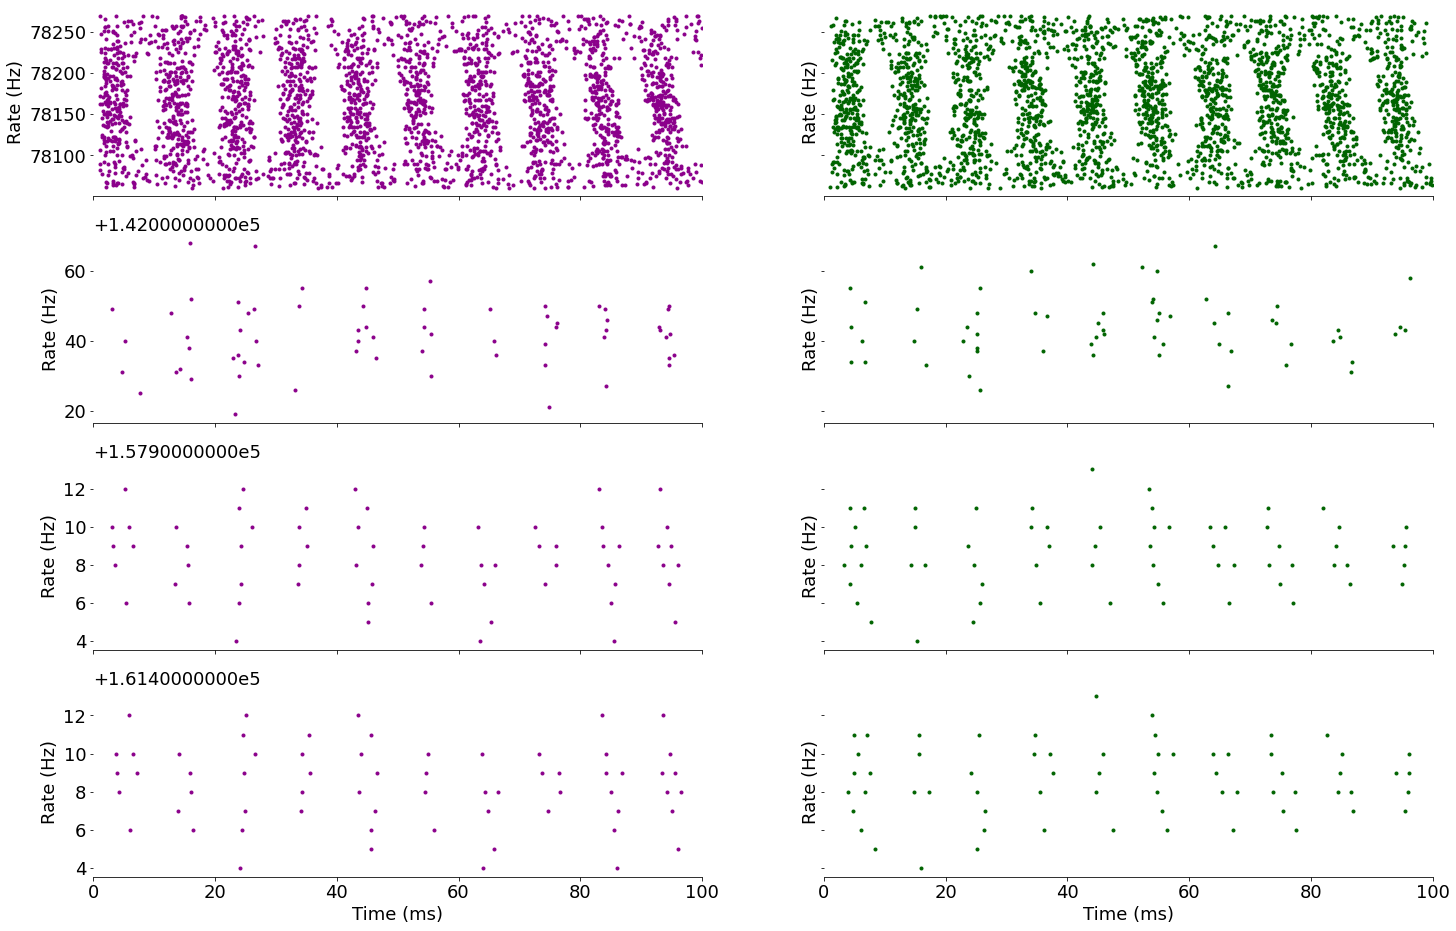

In [18]:
lim = 100

text_color = 'black' 
rcParams['text.color'] = text_color 
rcParams['axes.labelcolor'] = text_color 
rcParams['xtick.color'] = text_color 
rcParams['ytick.color'] = text_color 
plt.rc('font', size=16)          # controls default text sizes 
plt.rc('axes', titlesize=20)     # fontsize of the axes title 
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels 
plt.rc('legend', fontsize=16)    # legend fontsize 
plt.rc('figure', titlesize=26)  # fontsize of the figure title

fig, ax = plt.subplots(4,2, figsize = (24,16), sharex = True, sharey = 'row')
plt.xlim(0,lim)

ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['left'].set_visible(False)
ax[0,0].plot(data_l['times'][np.where(data_l['senders'] < id_l_SBC1)], data_l['senders'][np.where(data_l['senders'] < id_l_SBC1)] - id_l_ANF1 + id_r_ANF1, ".", color = 'darkmagenta')
ax[0,0].set_ylabel("Rate (Hz)")

ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['left'].set_visible(False)
ax[1,0].plot(data_l['times'][np.where((data_l['senders'] >= id_l_SBC1) & (data_l['senders'] < id_l_GBC1))], data_l['senders'][np.where((data_l['senders'] >= id_l_SBC1) & (data_l['senders'] < id_l_GBC1))]  - id_l_SBC1 + id_r_SBC1, ".", color = 'darkmagenta')
ax[1,0].set_ylabel("Rate (Hz)")

ax[2,0].spines['top'].set_visible(False)
ax[2,0].spines['right'].set_visible(False)
ax[2,0].spines['left'].set_visible(False)
ax[2,0].plot(data_l['times'][np.where((data_l['senders'] >= id_l_GBC1) & (data_l['senders'] < id_l_MNTBC1))], data_l['senders'][np.where((data_l['senders'] >= id_l_GBC1) & (data_l['senders'] < id_l_MNTBC1))]  - id_l_GBC1 + id_r_GBC1, ".", color = 'darkmagenta')
ax[2,0].set_ylabel("Rate (Hz)")

ax[3,0].spines['top'].set_visible(False)
ax[3,0].spines['right'].set_visible(False)
ax[3,0].spines['left'].set_visible(False)
ax[3,0].plot(data_l['times'][np.where((data_l['senders'] >= id_l_MNTBC1) & (data_l['senders'] < id_l_MSO1))], data_l['senders'][np.where((data_l['senders'] >= id_l_MNTBC1) & (data_l['senders'] < id_l_MSO1))] - id_l_MNTBC1 + id_r_MNTBC1, ".", color = 'darkmagenta')
ax[3,0].set_ylabel("Rate (Hz)")
ax[3,0].set_xlabel("Time (ms)")

ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['left'].set_visible(False)
ax[0,1].plot(data_r['times'][np.where(data_r['senders'] < id_r_SBC1)], data_r['senders'][np.where(data_r['senders'] < id_r_SBC1)], ".", color = 'darkgreen')
ax[0,1].set_ylabel("Rate (Hz)")

ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['left'].set_visible(False)
ax[1,1].plot(data_r['times'][np.where((data_r['senders'] >= id_r_SBC1) & (data_r['senders'] < id_r_GBC1))], data_r['senders'][np.where((data_r['senders'] >= id_r_SBC1) & (data_r['senders'] < id_r_GBC1))], ".", color = 'darkgreen')
ax[1,1].set_ylabel("Rate (Hz)")

ax[2,1].spines['top'].set_visible(False)
ax[2,1].spines['right'].set_visible(False)
ax[2,1].spines['left'].set_visible(False)
ax[2,1].plot(data_r['times'][np.where((data_r['senders'] >= id_r_GBC1) & (data_r['senders'] < id_r_MNTBC1))], data_r['senders'][np.where((data_r['senders'] >= id_r_GBC1) & (data_r['senders'] < id_r_MNTBC1))], ".", color = 'darkgreen')
ax[2,1].set_ylabel("Rate (Hz)")

ax[3,1].spines['top'].set_visible(False)
ax[3,1].spines['right'].set_visible(False)
ax[3,1].spines['left'].set_visible(False)
ax[3,1].plot(data_r['times'][np.where((data_r['senders'] >= id_r_MNTBC1) & (data_r['senders'] < id_r_MSO1))], data_r['senders'][np.where((data_r['senders'] >= id_r_MNTBC1) & (data_r['senders'] < id_r_MSO1))], ".", color = 'darkgreen')
ax[3,1].set_ylabel("Rate (Hz)")
ax[3,1].set_xlabel("Time (ms)")

#plt.savefig('plot.png', transparent=True)

In [21]:
bin_dim = 0.5 #ms

hist_r_ANFs = np.zeros(int(time_sim/bin_dim))
hist_l_ANFs = np.zeros(int(time_sim/bin_dim))

for i in ac_r_anf:
    t_r = data_r['times'][np.where(data_r['senders'] == i)]
    s_r, bins = np.histogram(t_r, np.arange(0,time_sim+bin_dim,bin_dim))
    hist_r_ANFs = hist_r_ANFs + s_r
    
for i in ac_l_anf:
    t_l = data_l['times'][np.where(data_l['senders'] == i)]
    s_l, bins = np.histogram(t_l, np.arange(0,time_sim+bin_dim,bin_dim))
    hist_l_ANFs = hist_l_ANFs + s_l
    
hist_r_SBCs = np.zeros(int(time_sim/bin_dim))
hist_l_SBCs = np.zeros(int(time_sim/bin_dim))

for i in ac_r_sbc:
    t_r = data_r['times'][np.where(data_r['senders'] == i)]
    s_r, bins = np.histogram(t_r, np.arange(0,time_sim+bin_dim,bin_dim))
    hist_r_SBCs = hist_r_SBCs + s_r
    
for i in ac_l_sbc:
    t_l = data_l['times'][np.where(data_l['senders'] == i)]
    s_l, bins = np.histogram(t_l, np.arange(0,time_sim+bin_dim,bin_dim))
    hist_l_SBCs = hist_l_SBCs + s_l
    
hist_r_GBCs = np.zeros(int(time_sim/bin_dim))
hist_l_GBCs = np.zeros(int(time_sim/bin_dim))

for i in ac_r_gbc:
    t_r = data_r['times'][np.where(data_r['senders'] == i)]
    s_r, bins = np.histogram(t_r, np.arange(0,time_sim+bin_dim,bin_dim))
    hist_r_GBCs = hist_r_GBCs + s_r
    
for i in ac_l_gbc:
    t_l = data_l['times'][np.where(data_l['senders'] == i)]
    s_l, bins = np.histogram(t_l, np.arange(0,time_sim+bin_dim,bin_dim))
    hist_l_GBCs = hist_l_GBCs + s_l

hist_r_MNTBCs = np.zeros(int(time_sim/bin_dim))
hist_l_MNTBCs = np.zeros(int(time_sim/bin_dim))

for i in ac_r_mntbc:
    t_r = data_r['times'][np.where(data_r['senders'] == i)]
    s_r, bins = np.histogram(t_r, np.arange(0,time_sim+bin_dim,bin_dim))
    hist_r_MNTBCs = hist_r_MNTBCs + s_r
    
for i in ac_l_mntbc:
    t_l = data_l['times'][np.where(data_l['senders'] == i)]
    s_l, bins = np.histogram(t_l, np.arange(0,time_sim+bin_dim,bin_dim))
    hist_l_MNTBCs = hist_l_MNTBCs + s_l

Text(0.5, 0, 'Time [ms]')

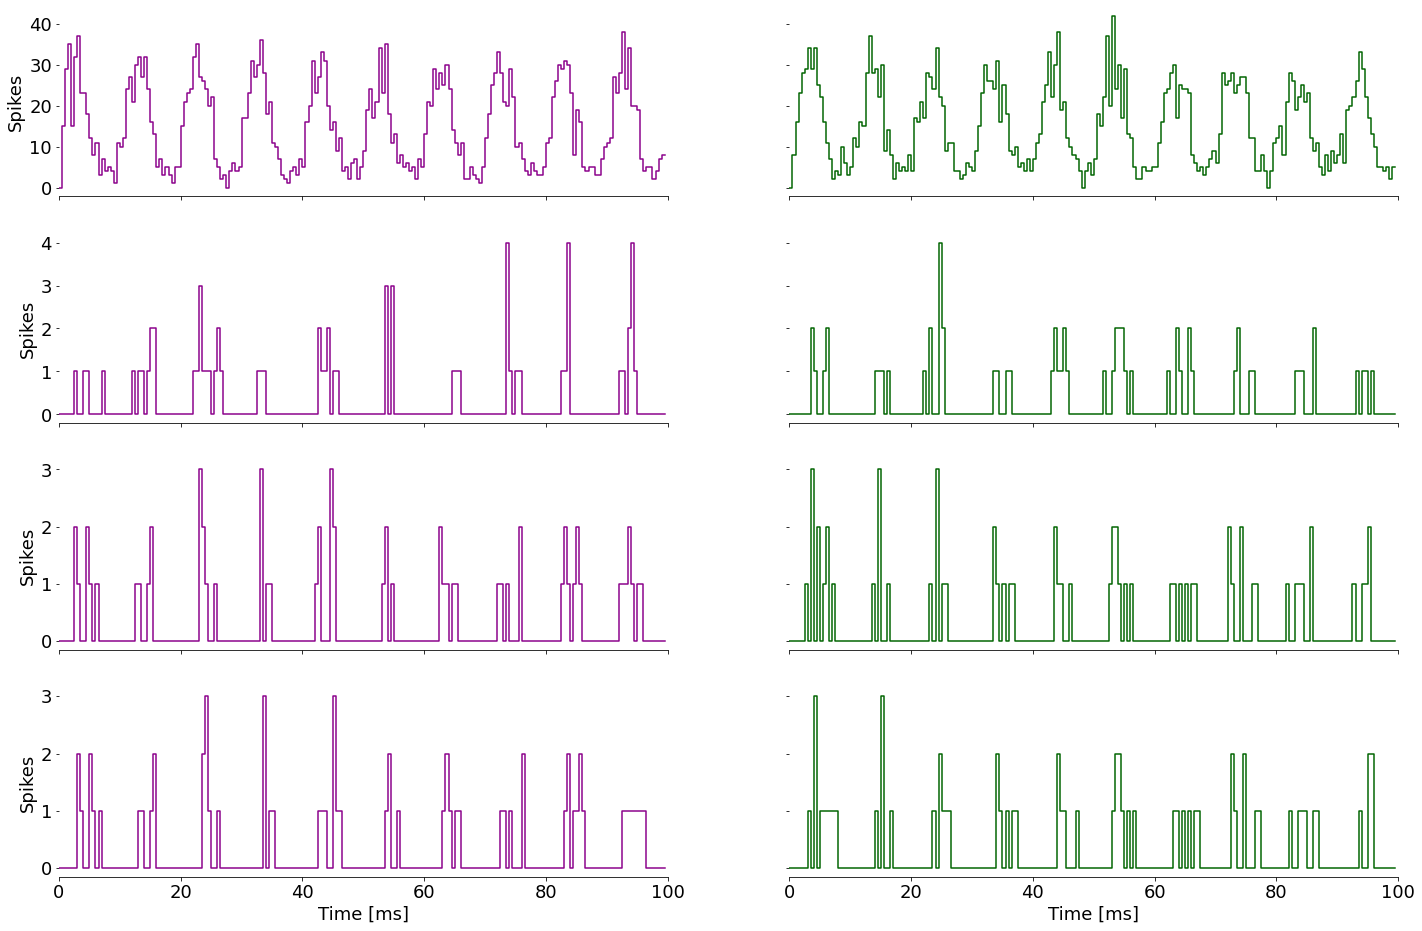

In [22]:
lim = 100

text_color = 'black' 
rcParams['text.color'] = text_color 
rcParams['axes.labelcolor'] = text_color 
rcParams['xtick.color'] = text_color 
rcParams['ytick.color'] = text_color 
plt.rc('font', size=16)          # controls default text sizes 
plt.rc('axes', titlesize=20)     # fontsize of the axes title 
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels 
plt.rc('legend', fontsize=16)    # legend fontsize 
plt.rc('figure', titlesize=26)  # fontsize of the figure title

fig, ax = plt.subplots(4,2, figsize = (24,16), sharex = True, sharey = 'row')
plt.xlim(0,lim)

ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['left'].set_visible(False)
ax[0,0].step(bins[:-1], hist_l_ANFs, color = 'darkmagenta')
ax[0,0].set_ylabel("Spikes")

ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['left'].set_visible(False)
ax[1,0].step(bins[:-1], hist_l_SBCs, color = 'darkmagenta')
ax[1,0].set_ylabel("Spikes")

ax[2,0].spines['top'].set_visible(False)
ax[2,0].spines['right'].set_visible(False)
ax[2,0].spines['left'].set_visible(False)
ax[2,0].step(bins[:-1], hist_l_GBCs, color = 'darkmagenta')
ax[2,0].set_ylabel("Spikes")

ax[3,0].spines['top'].set_visible(False)
ax[3,0].spines['right'].set_visible(False)
ax[3,0].spines['left'].set_visible(False)
ax[3,0].step(bins[:-1], hist_l_MNTBCs, color = 'darkmagenta')
ax[3,0].set_ylabel("Spikes")
ax[3,0].set_xlabel("Time [ms]")

ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['left'].set_visible(False)
ax[0,1].step(bins[:-1], hist_r_ANFs, color = 'darkgreen')

ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['left'].set_visible(False)
ax[1,1].step(bins[:-1], hist_r_SBCs, color = 'darkgreen')

ax[2,1].spines['top'].set_visible(False)
ax[2,1].spines['right'].set_visible(False)
ax[2,1].spines['left'].set_visible(False)
ax[2,1].step(bins[:-1], hist_r_GBCs, color = 'darkgreen')

ax[3,1].spines['top'].set_visible(False)
ax[3,1].spines['right'].set_visible(False)
ax[3,1].spines['left'].set_visible(False)
ax[3,1].step(bins[:-1], hist_r_MNTBCs, color = 'darkgreen')
ax[3,1].set_xlabel("Time [ms]")

In [ ]:
lim = 10

text_color = 'black' 
rcParams['text.color'] = text_color 
rcParams['axes.labelcolor'] = text_color 
rcParams['xtick.color'] = text_color 
rcParams['ytick.color'] = text_color 
plt.rc('font', size=16)          # controls default text sizes 
plt.rc('axes', titlesize=20)     # fontsize of the axes title 
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels 
plt.rc('legend', fontsize=16)    # legend fontsize 
plt.rc('figure', titlesize=26)  # fontsize of the figure title

fig, ax = plt.subplots(4,2, figsize = (24,16), sharex = True, sharey = 'row')
plt.xlim(0,lim)

ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['left'].set_visible(False)
ax[0,0].step(bins[:-1], hist_l_ANFs, color = 'darkmagenta')
ax[0,0].set_ylabel("Spikes")

ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['left'].set_visible(False)
ax[1,0].step(bins[:-1], hist_l_SBCs, color = 'darkmagenta')
ax[1,0].set_ylabel("Spikes")

ax[2,0].spines['top'].set_visible(False)
ax[2,0].spines['right'].set_visible(False)
ax[2,0].spines['left'].set_visible(False)
ax[2,0].step(bins[:-1], hist_l_GBCs, color = 'darkmagenta')
ax[2,0].set_ylabel("Spikes")

ax[3,0].spines['top'].set_visible(False)
ax[3,0].spines['right'].set_visible(False)
ax[3,0].spines['left'].set_visible(False)
ax[3,0].step(bins[:-1], hist_l_MNTBCs, color = 'darkmagenta')
ax[3,0].set_ylabel("Spikes")
ax[3,0].set_xlabel("Time [ms]")


ax[0,0].step(bins[:-1], hist_r_ANFs, color = 'darkgreen')

ax[1,0].step(bins[:-1], hist_r_SBCs, color = 'darkgreen')

ax[2,0].step(bins[:-1], hist_r_GBCs, color = 'darkgreen')

ax[3,0].step(bins[:-1], hist_r_MNTBCs, color = 'darkgreen')

In [ ]:
hist_r_ANFs = hist_r_ANFs/len(ac_r_anf)
hist_l_ANFs = hist_l_ANFs/len(ac_l_anf)

hist_r_SBCs = hist_r_SBCs/len(ac_r_sbc)
hist_l_SBCs = hist_l_SBCs/len(ac_l_sbc)

hist_r_GBCs = hist_r_GBCs/len(ac_r_gbc)
hist_l_GBCs = hist_l_GBCs/len(ac_l_gbc)

hist_r_MNTBCs = hist_r_MNTBCs/len(ac_r_mntbc)
hist_l_MNTBCs = hist_l_MNTBCs/len(ac_l_mntbc)

In [ ]:
lim = 100

text_color = 'black' 
rcParams['text.color'] = text_color 
rcParams['axes.labelcolor'] = text_color 
rcParams['xtick.color'] = text_color 
rcParams['ytick.color'] = text_color 
plt.rc('font', size=16)          # controls default text sizes 
plt.rc('axes', titlesize=20)     # fontsize of the axes title 
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels 
plt.rc('legend', fontsize=16)    # legend fontsize 
plt.rc('figure', titlesize=26)  # fontsize of the figure title

fig, ax = plt.subplots(4,2, figsize = (24,16), sharex = True, sharey = 'row')
plt.xlim(0,lim)

ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['left'].set_visible(False)
ax[0,0].step(bins[:-1], hist_l_ANFs*1000/bin_dim, color = 'darkmagenta')
ax[0,0].set_ylabel("Rate [Hz]")

ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['left'].set_visible(False)
ax[1,0].step(bins[:-1], hist_l_SBCs*1000/bin_dim, color = 'darkmagenta')
ax[1,0].set_ylabel("Rate [Hz]")

ax[2,0].spines['top'].set_visible(False)
ax[2,0].spines['right'].set_visible(False)
ax[2,0].spines['left'].set_visible(False)
ax[2,0].step(bins[:-1], hist_l_GBCs*1000/bin_dim, color = 'darkmagenta')
ax[2,0].set_ylabel("Rate [Hz]")

ax[3,0].spines['top'].set_visible(False)
ax[3,0].spines['right'].set_visible(False)
ax[3,0].spines['left'].set_visible(False)
ax[3,0].step(bins[:-1], hist_l_MNTBCs*1000/bin_dim, color = 'darkmagenta')
ax[3,0].set_ylabel("Rate [Hz]")
ax[3,0].set_xlabel("Time [ms]")

ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['left'].set_visible(False)
ax[0,1].step(bins[:-1], hist_r_ANFs*1000/bin_dim, color = 'darkgreen')

ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['left'].set_visible(False)
ax[1,1].step(bins[:-1], hist_r_SBCs*1000/bin_dim, color = 'darkgreen')

ax[2,1].spines['top'].set_visible(False)
ax[2,1].spines['right'].set_visible(False)
ax[2,1].spines['left'].set_visible(False)
ax[2,1].step(bins[:-1], hist_r_GBCs*1000/bin_dim, color = 'darkgreen')

ax[3,1].spines['top'].set_visible(False)
ax[3,1].spines['right'].set_visible(False)
ax[3,1].spines['left'].set_visible(False)
ax[3,1].step(bins[:-1], hist_r_MNTBCs*1000/bin_dim, color = 'darkgreen')
ax[3,1].set_xlabel("Time [ms]")


ax[0,0].axhline(400, color = 'r')
ax[0,0].axhline(200, color = 'b')
ax[0,0].set_ylim(0,500)
ax[0,1].axhline(400, color = 'r')
ax[0,1].axhline(200, color = 'b')

In [ ]:
text_color = 'black' 
rcParams['text.color'] = text_color 
rcParams['axes.labelcolor'] = text_color 
rcParams['xtick.color'] = text_color 
rcParams['ytick.color'] = text_color 
plt.rc('font', size=16)          # controls default text sizes 
plt.rc('axes', titlesize=20)     # fontsize of the axes title 
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels 
plt.rc('legend', fontsize=16)    # legend fontsize 
plt.rc('figure', titlesize=26)  # fontsize of the figure title

fig, ax = plt.subplots(1,figsize = (24,6), sharex = 'col', sharey = 'row')
plt.xlim(0,time_sim)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.step(bins[:-1], hist_l_ANFs*1000/bin_dim, color = 'darkmagenta')
ax.set_ylabel("Rate [Hz]")
ax.step(bins[:-1], hist_r_ANFs*1000/bin_dim, color = 'darkgreen')
ax.set_xlabel("Time [ms]")

# LSOs

In [ ]:
print("Activty LSOs l/r: ", rate_l_lso, "spikes /", rate_r_lso, "spikes")
print("Active LSOs l/r: ", len(ac_l_lso), "cells/", len(ac_r_lso), "cells")
print("Rate LSOs l/r: ", int(rate_l_lso/len(ac_l_lso)), "Hz /", int(rate_r_lso/len(ac_r_lso)), "Hz")

In [ ]:
hist_r_LSOs = np.zeros(int(time_sim/bin_dim))
hist_l_LSOs = np.zeros(int(time_sim/bin_dim))

for i in ac_r_lso:
    t_r = data_r['times'][np.where(data_r['senders'] == i)]
    s_r, bins = np.histogram(t_r, np.arange(0,time_sim+bin_dim,bin_dim))
    hist_r_LSOs = hist_r_LSOs + s_r
    
for i in ac_l_lso:
    t_l = data_l['times'][np.where(data_l['senders'] == i)]
    s_l, bins = np.histogram(t_l, np.arange(0,time_sim+bin_dim,bin_dim))
    hist_l_LSOs = hist_l_LSOs + s_l

hist_r_LSOs = hist_r_LSOs/len(ac_r_lso)
hist_l_LSOs = hist_l_LSOs/len(ac_l_lso)

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (24,4), sharey = 'row')
plt.xlim(0,time_sim)

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].step(bins[:-1], hist_l_LSOs*1000/bin_dim, color = 'darkmagenta')
ax[0].set_xlabel("Time [ms]")
ax[0].set_ylabel("Rate [Hz]")

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].step(bins[:-1], hist_r_LSOs*1000/bin_dim, color = 'darkgreen')
ax[1].set_xlabel("Time [ms]")

In [ ]:
text_color = 'black' 
rcParams['text.color'] = text_color 
rcParams['axes.labelcolor'] = text_color 
rcParams['xtick.color'] = text_color 
rcParams['ytick.color'] = text_color 
plt.rc('font', size=16)          # controls default text sizes 
plt.rc('axes', titlesize=20)     # fontsize of the axes title 
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels 
plt.rc('legend', fontsize=16)    # legend fontsize 
plt.rc('figure', titlesize=26)  # fontsize of the figure title

fig, ax = plt.subplots(5,2, figsize = (24,16), sharex = 'col', sharey = 'row')
plt.xlim(0,time_sim)

ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['left'].set_visible(False)
ax[0,0].step(bins[:-1], hist_l_ANFs*1000/bin_dim, color = 'darkmagenta')
ax[0,0].set_ylabel("Rate [Hz]")

ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['left'].set_visible(False)
ax[1,0].step(bins[:-1], hist_l_SBCs*1000/bin_dim, color = 'darkmagenta')
ax[1,0].set_ylabel("Rate [Hz]")

ax[2,0].spines['top'].set_visible(False)
ax[2,0].spines['right'].set_visible(False)
ax[2,0].spines['left'].set_visible(False)
ax[2,0].step(bins[:-1], hist_l_GBCs*1000/bin_dim, color = 'darkmagenta')
ax[2,0].set_ylabel("Rate [Hz]")

ax[3,0].spines['top'].set_visible(False)
ax[3,0].spines['right'].set_visible(False)
ax[3,0].spines['left'].set_visible(False)
ax[3,0].step(bins[:-1], hist_l_MNTBCs*1000/bin_dim, color = 'darkmagenta')
ax[3,0].set_ylabel("Rate [Hz]")

ax[4,0].spines['top'].set_visible(False)
ax[4,0].spines['right'].set_visible(False)
ax[4,0].spines['left'].set_visible(False)
ax[4,0].step(bins[:-1], hist_l_LSOs*1000/bin_dim, color = 'darkmagenta')
ax[4,0].set_ylabel("Rate [Hz]")
ax[4,0].set_xlabel("Time [ms]")

ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['left'].set_visible(False)
ax[0,1].step(bins[:-1], hist_r_ANFs*1000/bin_dim, color = 'darkgreen')

ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['left'].set_visible(False)
ax[1,1].step(bins[:-1], hist_r_SBCs*1000/bin_dim, color = 'darkgreen')

ax[2,1].spines['top'].set_visible(False)
ax[2,1].spines['right'].set_visible(False)
ax[2,1].spines['left'].set_visible(False)
ax[2,1].step(bins[:-1], hist_r_GBCs*1000/bin_dim, color = 'darkgreen')

ax[3,1].spines['top'].set_visible(False)
ax[3,1].spines['right'].set_visible(False)
ax[3,1].spines['left'].set_visible(False)
ax[3,1].step(bins[:-1], hist_r_MNTBCs*1000/bin_dim, color = 'darkgreen')

ax[4,1].spines['top'].set_visible(False)
ax[4,1].spines['right'].set_visible(False)
ax[4,1].spines['left'].set_visible(False)
ax[4,1].step(bins[:-1], hist_r_LSOs*1000/bin_dim, color = 'darkgreen')
ax[4,1].set_xlabel("Time [ms]")

# MSOs

In [ ]:
for j in range(len(MNTBCs2MSO_weights)):
    print("Inhibition Weight:", MNTBCs2MSO_weights[j], "nS")
    print("Activty MSOs l/r: ", rate_l_mso[j], "spikes /", rate_r_mso[j], "spikes")
    print("Active MSOs l/r: ", n_ac_l_mso[j], "cells/", n_ac_r_mso[j], "cells")
    print("Rate MSOs l/r: ", int(rate_l_mso[j]/n_ac_l_mso[j]), "Hz /", int(rate_r_mso[j]/n_ac_r_mso[j]), "Hz")
    print("----------------------------------------------\n")

In [ ]:
hist_r_MSOs = np.zeros((len(MNTBCs2MSO_weights), int(time_sim/bin_dim)))
hist_l_MSOs = np.zeros((len(MNTBCs2MSO_weights), int(time_sim/bin_dim)))

for i in range(ac_r_mso.shape[0]):
    for j in range(ac_r_mso.shape[1]):
        t_r = data_r['times'][np.where(data_r['senders'] == ac_r_mso[i,j])]
        s_r, bins = np.histogram(t_r, np.arange(0,time_sim+bin_dim,bin_dim))
        hist_r_MSOs[j] = hist_r_MSOs[j] + s_r
        
        """"if(ac_r_mso[i,j]!=0):
            print(ac_r_mso[i,j])
            print(t_r)
            print(hist_r_MSOs[j])
            print("------------------")"""

for i in range(ac_l_mso.shape[0]):
    for j in range(ac_l_mso.shape[1]):
        t_l = data_l['times'][np.where(data_l['senders'] == ac_l_mso[i,j])]
        s_l, bins = np.histogram(t_l, np.arange(0,time_sim+bin_dim,bin_dim))
        hist_l_MSOs[j] = hist_l_MSOs[j] + s_l
        
for j in range(ac_l_mso.shape[1]):
    hist_r_MSOs[j]/=n_ac_r_mso[j]
    hist_l_MSOs[j]/=n_ac_l_mso[j]

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (24,4))
plt.xlim(0,time_sim)

for j in range(len(MNTBCs2MSO_weights)):
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['left'].set_visible(False)
    ax[0].step(bins[:-1], hist_l_MSOs[j]*1000/bin_dim, color = 'darkmagenta', alpha=0.2)
    ax[0].set_xlabel("Time [ms]")
    ax[0].set_ylabel("Rate [Hz]")

    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].step(bins[:-1], hist_r_MSOs[j]*1000/bin_dim, color = 'darkgreen', alpha=0.2)
    ax[1].set_xlabel("Time [ms]")

In [ ]:
text_color = 'black' 
rcParams['text.color'] = text_color 
rcParams['axes.labelcolor'] = text_color 
rcParams['xtick.color'] = text_color 
rcParams['ytick.color'] = text_color 
plt.rc('font', size=16)          # controls default text sizes 
plt.rc('axes', titlesize=20)     # fontsize of the axes title 
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels 
plt.rc('legend', fontsize=16)    # legend fontsize 
plt.rc('figure', titlesize=26)  # fontsize of the figure title

fig, ax = plt.subplots(6,2, figsize = (24,16), sharex = 'col', sharey = 'row')
plt.xlim(0,time_sim)

ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['left'].set_visible(False)
ax[0,0].step(bins[:-1], hist_l_ANFs*1000/bin_dim, color = 'darkmagenta')
ax[0,0].set_ylabel("Rate [Hz]")

ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['left'].set_visible(False)
ax[1,0].step(bins[:-1], hist_l_SBCs*1000/bin_dim, color = 'darkmagenta')
ax[1,0].set_ylabel("Rate [Hz]")

ax[2,0].spines['top'].set_visible(False)
ax[2,0].spines['right'].set_visible(False)
ax[2,0].spines['left'].set_visible(False)
ax[2,0].step(bins[:-1], hist_l_GBCs*1000/bin_dim, color = 'darkmagenta')
ax[2,0].set_ylabel("Rate [Hz]")

ax[3,0].spines['top'].set_visible(False)
ax[3,0].spines['right'].set_visible(False)
ax[3,0].spines['left'].set_visible(False)
ax[3,0].step(bins[:-1], hist_l_MNTBCs*1000/bin_dim, color = 'darkmagenta')
ax[3,0].set_ylabel("Rate [Hz]")

ax[4,0].spines['top'].set_visible(False)
ax[4,0].spines['right'].set_visible(False)
ax[4,0].spines['left'].set_visible(False)
ax[4,0].step(bins[:-1], hist_l_LSOs*1000/bin_dim, color = 'darkmagenta')
ax[4,0].set_ylabel("Rate [Hz]")

ax[5,0].spines['top'].set_visible(False)
ax[5,0].spines['right'].set_visible(False)
ax[5,0].spines['left'].set_visible(False)
ax[5,0].step(bins[:-1], hist_l_MSOs[0]*1000/bin_dim, color = 'darkmagenta')
ax[5,0].set_ylabel("Rate [Hz]")
ax[5,0].set_xlabel("Time [ms]")

ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['left'].set_visible(False)
ax[0,1].step(bins[:-1], hist_r_ANFs*1000/bin_dim, color = 'darkgreen')

ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['left'].set_visible(False)
ax[1,1].step(bins[:-1], hist_r_SBCs*1000/bin_dim, color = 'darkgreen')

ax[2,1].spines['top'].set_visible(False)
ax[2,1].spines['right'].set_visible(False)
ax[2,1].spines['left'].set_visible(False)
ax[2,1].step(bins[:-1], hist_r_GBCs*1000/bin_dim, color = 'darkgreen')

ax[3,1].spines['top'].set_visible(False)
ax[3,1].spines['right'].set_visible(False)
ax[3,1].spines['left'].set_visible(False)
ax[3,1].step(bins[:-1], hist_r_MNTBCs*1000/bin_dim, color = 'darkgreen')

ax[4,1].spines['top'].set_visible(False)
ax[4,1].spines['right'].set_visible(False)
ax[4,1].spines['left'].set_visible(False)
ax[4,1].step(bins[:-1], hist_r_LSOs*1000/bin_dim, color = 'darkgreen')

ax[5,1].spines['top'].set_visible(False)
ax[5,1].spines['right'].set_visible(False)
ax[5,1].spines['left'].set_visible(False)
ax[5,1].step(bins[:-1], hist_r_MSOs[0]*1000/bin_dim, color = 'darkgreen')
ax[5,1].set_xlabel("Time [ms]")